In [84]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# function to read the images by taking there path
def read_image(path1,path2):
    read_img1 = cv2.imread(path1)
    read_img2 = cv2.imread(path2)
    return (read_img1,read_img2)
 
# function to convert images from RGB to gray scale 
def convert_to_grayscale(pic1,pic2):
    gray_img1 = cv2.cvtColor(pic1,cv2.COLOR_BGR2GRAY)
    gray_img2 = cv2.cvtColor(pic2,cv2.COLOR_BGR2GRAY)
    return (gray_img1,gray_img2)
 
# function to detect the features by finding key points 
# and descriptors from the image
def detector(image1,image2):
    # creating ORB detector
    detect = cv2.ORB_create()
 
    # finding key points and descriptors of both images 
    # using detectAndCompute() function
    key_point1,descrip1 = detect.detectAndCompute(image1,None)
    key_point2,descrip2 = detect.detectAndCompute(image2,None)
    return (key_point1,descrip1,key_point2,descrip2)
 
# function to find best detected features using brute 
# force matcher and match them according to their humming distance
def BF_FeatureMatcher(des1,des2):
    brute_force = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
    no_of_matches = brute_force.match(des1,des2)
 
    # finding the humming distance of the matches and sorting them
    no_of_matches = sorted(no_of_matches,key=lambda x: x.distance)
    return no_of_matches
 
# function displaying the output image with the feature matching
def display_output(pic1,kpt1,pic2,kpt2,best_match):
    # drawing the feature matches using drawMatches() function
    output_image = cv2.drawMatches(pic1,kpt1,pic2,
                                   kpt2,best_match[:30],None,flags=2)
    cv2.imshow('Output image',output_image)

In [85]:
# function to verify file pathway is valid
def directory_verification(directory): 
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        exit()

# function to verify file is an image
def file_verification(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))

# function to read the images and perform the transformations of the image before use in the ORB algorithm
def transform_image(file_path, image_template):
    img1, img2 = read_image(file_path, image_template) # reads the images
    gray_pic1, gray_pic2 = convert_to_grayscale(img1, img2) # converts the images to grayscale
    return gray_pic1, gray_pic2

# function to process the image using the ORB algorithm and apply the brute force feature matcher
def use_algorithm(gray_pic1, gray_pic2, filename):
    key_pt1, descrip1, key_pt2, descrip2 = detector(gray_pic1, gray_pic2) # finds the key points and descriptors
    number_of_matches = BF_FeatureMatcher(descrip1, descrip2) # finds the total number of matches
    tot_feature_matches = len(number_of_matches)
    print(f'Total Number of Features matches found are {tot_feature_matches}')
    
    results = cv2.drawMatches(gray_pic1, key_pt1, gray_pic2, key_pt2, number_of_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(14, 8))
    plt.imshow(results, cmap="gray")
    plt.title("Feature Matching Using ORB")
    plt.axis("off")
    plt.savefig(f"processed-images/processed-{filename}")
    plt.close(fig=None)


image_directory = "/Users/louie/Downloads/airbus-aircrafts-sample-dataset/images"
image_template = '/Users/louie/Downloads/aircraft_template2.jpg'
    
directory_verification(image_directory)
    
for filename in os.listdir(image_directory):
    file_path = os.path.join(image_directory, filename)
    if file_verification(filename):
        process_image(file_path, image_template, filename)
    else:
        print(f"Skipping non-image file: {filename}")
    
print("Finished processing the dataset.")

Processing image: 014de911-7810-4f7d-8967-3e5402209f4a.jpg
Image size: (2560, 2560), Image mode: RGB
Total Number of Features matches found are 52
Processing image: 0263270b-e3ee-41dc-aeef-43ff77e66d5b.jpg
Image size: (2560, 2560), Image mode: RGB
Total Number of Features matches found are 50
Processing image: 03f84930-e2be-4c19-9afc-0dc26d02538e.jpg
Image size: (2560, 2560), Image mode: RGB
Total Number of Features matches found are 48
Processing image: 0641acc3-c0b9-4f9d-b0ba-7ad18aa08864.jpg
Image size: (2560, 2560), Image mode: RGB
Total Number of Features matches found are 46
Processing image: 074737f4-7f59-4729-be5d-67f6f1d34668.jpg
Image size: (2560, 2560), Image mode: RGB
Total Number of Features matches found are 61
Processing image: 11928d1c-44c7-4d3d-b593-9cdfd5f6f367.jpg
Image size: (2560, 2560), Image mode: RGB
Total Number of Features matches found are 50
Processing image: 12210ad7-83f8-4b54-bb4b-e93f8ff6ac1f.jpg
Image size: (2560, 2560), Image mode: RGB
Total Number of F

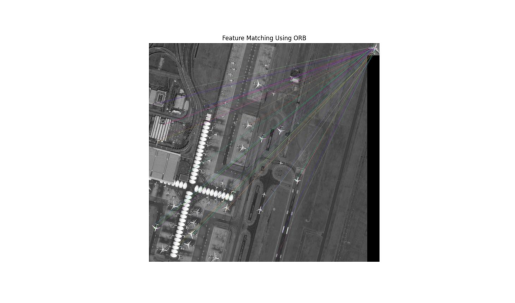

In [ ]:
# Display a random image from the processed images

image_directory = "/Users/louie/Documents/Visual Studio Code/ACT Work/Airbus-Aircraft-Detection/py/Question 1/processed-images"
random_image = np.random.choice(os.listdir(image_directory))
image_path = os.path.join(image_directory, random_image)
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  
plt.show()

In [ ]:
# Code was adapted from the following sources:
# https://www.geeksforgeeks.org/feature-matching-using-brute-force-in-opencv/
# https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
# ChatGPT